<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/cyclicLR_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import optim
from torch import nn
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import CyclicLR

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(3),
                                transforms.ToTensor()                                
])

dataset = datasets.MNIST('./data', train=False, download=True)

In [3]:
class LoadData(Dataset):
  def __init__(self, data, target, transform):
    super().__init__()
    self.data = data
    self.target = target
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.transform(self.data[idx]), self.target[idx])


In [5]:
trainloader = DataLoader(LoadData(dataset.data[:8000], dataset.targets[:8000], transform), 32, shuffle=True)
valloader = DataLoader(LoadData(dataset.data[8000:], dataset.targets[8000:], transform), 32)

In [6]:
for data, label in trainloader:
  print(data.shape, label)
  break

for data, label in valloader:
  print(data.shape, label)
  break

torch.Size([32, 3, 28, 28]) tensor([3, 1, 4, 5, 2, 5, 6, 5, 5, 8, 5, 4, 5, 9, 7, 5, 7, 7, 3, 9, 9, 3, 2, 1,
        5, 7, 1, 3, 9, 5, 9, 8])
torch.Size([32, 3, 28, 28]) tensor([4, 9, 9, 7, 1, 1, 9, 0, 7, 8, 3, 4, 8, 6, 3, 8, 0, 9, 6, 2, 1, 0, 1, 0,
        6, 2, 3, 8, 9, 0, 7, 2])


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

scheduler = CyclicLR(opt, base_lr=3e-3, max_lr=1e-2, step_size_up=2*len(trainloader), cycle_momentum=False)

In [14]:
model = model.to(device)

In [16]:
epochs = 8
losses = []
val_losses = []
lr = []

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for data, labels in tqdm(trainloader, total=len(trainloader), leave=False):

    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    losses.append(loss.item())
    lr.append(opt.param_groups[0]['lr'])

    scheduler.step()

  model.eval()
  for valdata, vallabels in tqdm(valloader, total=len(valloader), leave=False):
    val_out = model(valdata.to(device))
    val_loss = criterion(val_out, vallabels.to(device))

    val_losses.append(val_loss.item())

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {val_loss.item()}\t\n") 

Epoch: 1/8	train_loss: 0.6665546894073486	val_loss: 0.48215457797050476	



Epoch: 2/8	train_loss: 0.4270450472831726	val_loss: 0.14445798099040985	



Epoch: 3/8	train_loss: 0.019737206399440765	val_loss: 0.0011197077110409737	



Epoch: 4/8	train_loss: 0.009916645474731922	val_loss: 0.000678317912388593	



Epoch: 5/8	train_loss: 0.0745701938867569	val_loss: 0.0014818930067121983	



Epoch: 6/8	train_loss: 0.04329322278499603	val_loss: 0.0007759008440189064	



Epoch: 7/8	train_loss: 0.035006001591682434	val_loss: 0.0014016618952155113	



Epoch: 8/8	train_loss: 0.006881880573928356	val_loss: 0.0006211479776538908	



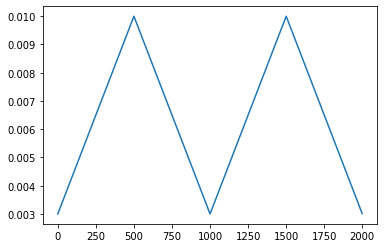

In [19]:
plt.plot(lr)

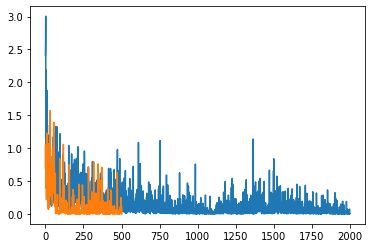

In [20]:
plt.plot(losses)
plt.plot(val_losses)